# Data

In [1]:
random_state=190624

### Raw

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import joblib
import itertools
%matplotlib inline


import sys
import os
sys.path.append(os.path.join(
    os.path.abspath(os.path.pardir), 'src'
))

import nzcompetition
from nzcompetition.preparation import make_prep_pipeline

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import (
    Ridge, 
    Lasso, 
    ElasticNet, 
    ElasticNetCV, 
)
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, 
    AdaBoostRegressor
)
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [4]:
y_col = 'odor'
# for plotting
lim=[0, 3.5]

In [5]:
X_train, y, X_test = nzcompetition.get_raw_data(target=y_col)
X_train, y = nzcompetition.drop_dup(X_train, y)

In [6]:
print(X_train.shape, y.shape, X_test.shape)

(122, 114) (122,) (61, 114)


### Full features

In [7]:
prep_pipe = make_prep_pipeline()

In [8]:
X_train_prep = prep_pipe.fit_transform(X_train)

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:221: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


In [9]:
X_train_prep.shape

(122, 96)

In [10]:
X_test_prep = prep_pipe.transform(X_test)

/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:242: RuntimeWarning: Mean of empty slice
  protdf['pI'] = np.nanmean(protdf[['pI_u', 'pI_p', 'pI_green']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/seqtransform.py:246: RuntimeWarning: Mean of empty slice
  protdf['molweight'] = np.nanmean(protdf[['molweight_u', 'molweight_p']], axis=1)
/nfs/home/shya/projects/190624_datalyst_competition/src/nzcompetition/transform/numtransform.py:221: RuntimeWarning: Mean of empty slice
  df[newcol] = np.nanmean(df[origcols], axis=1)


In [11]:
X_test_prep.shape

(61, 96)

# Plots

In [12]:
def plot_train_pred(y, y_hat, lim):
    fig, ax = plt.subplots(1, 1, figsize=(6,6))

    ax.plot(y, y_hat, '.')
    ax.set_xlabel('training')
    ax.set_ylabel('cross validated prediction (CV=8)')
    ax.set_xlim(*lim)
    ax.set_ylim(*lim)
    ax.plot(lim, lim, '--', alpha=0.3)

    fig.show()

In [13]:
def plot_pred_distribution(y, y_hat, y_test):
    fig, axs = plt.subplots(1, 3, figsize=(15, 6), sharex=True)

    axs[0].hist(y)
    axs[0].set_title('distribution of y_train')

    axs[1].hist(y_hat)
    axs[1].set_title('distribution of predicted y')

    axs[2].hist(y_test)
    axs[2].set_title('distribution of y_test')

    fig.show()

# ElasticNet

In [14]:
params = dict(
    alpha=[0.001, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0], 
#    alpha=[0.03, 0.05, 0.08, 0.1], 
    l1_ratio=[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0], 
#    l1_ratio=[0.25, 0.3, 0.35, 0.4], 
), 

grid_search = GridSearchCV(
    ElasticNet(random_state=random_state), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [15]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 63 candidates, totalling 504 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.3min
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:  1.6min
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:  2.2min
[Parallel(n_jobs=12)]: Done 504 out of 504 | elapsed:  3.1min finished
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 21.325797389474122, tolerance: 0.006612778658382958
  positive)


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=190624, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid=False, n_jobs=12,
             param_grid=({'alpha': [0.001, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0,
                                    100.0, 300.0],
                          'l1_ratio': [0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0]},),
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=3)

In [16]:
grid_search.best_estimator_

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.0,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=190624, selection='cyclic', tol=0.0001,
           warm_start=False)

In [17]:
elanet = grid_search.best_estimator_

y_hat = elanet.predict(X_train_prep)

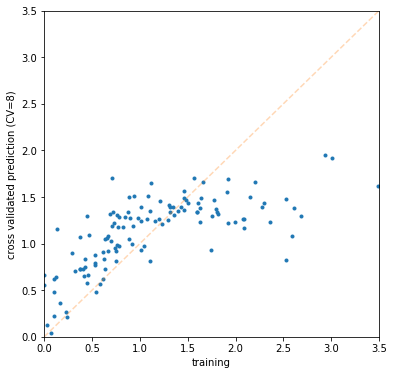

In [18]:
plot_train_pred(y, y_hat, lim)

In [19]:
mean_squared_error(y, y_hat)

0.2993263773803429

In [ ]:
y_test = elanet.predict(X_test_prep)

In [ ]:
plot_pred_distribution(y, y_hat, y_test)

In [ ]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/{}_elanet.csv'.format(y_col))

In [ ]:
joblib.dump(elanet, '../models/{}_elanet.pkl'.format(y_col))

# ElasticNet with PCA

In [ ]:
pca = PCA(0.98)

In [ ]:
X_train_pca = pca.fit_transform(X_train_prep)
X_test_pca = pca.transform(X_test_prep)

In [ ]:
params = dict(
#    alpha=[0.001, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 300.0], 
    alpha=[0.005, 0.01, 0.05, 0.08, 0.1, 0.2, 0.3, 1.0], 
#    l1_ratio=[0.0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0], 
#    l1_ratio=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4], 
    l1_ratio=[0.0, 0.05, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5], 
), 

grid_search = GridSearchCV(
    ElasticNet(random_state=random_state), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=10, 
    verbose=3, 
    iid=False, 
)

In [ ]:
grid_search.fit(X_train_pca, y)

In [ ]:
grid_search.best_estimator_

In [ ]:
elanet = grid_search.best_estimator_

y_hat = elanet.predict(X_train_pca)

In [ ]:
plot_train_pred(y, y_hat, lim)

In [ ]:
mean_squared_error(y, y_hat)

The PCA didn't help prediction.

# RandomForestRegressor

In [20]:
params = dict(
    max_depth=[3, 4, 5, 6], 
    max_features=['sqrt', 'log2', 'auto', 0.3, 0.5, 0.7], 
    min_samples_leaf=[3, 4], 
    min_samples_split=[3,4,5],
)

grid_search = GridSearchCV(
    RandomForestRegressor(n_estimators=100, random_state=random_state), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [21]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 144 candidates, totalling 1152 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   12.5s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   28.9s
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed:   37.3s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:   42.4s
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed:  1.0min
[Parallel(n_jobs=12)]: Done 1152 out of 1152 | elapsed:  1.1min finished


GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False,
                                             random_state=190624, verbose=0,
                                             warm_start=False),
             iid=False, n_jobs=12,
             pa

In [22]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='log2', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=190624,
                      verbose=0, warm_start=False)

In [23]:
randfor = grid_search.best_estimator_

y_hat = randfor.predict(X_train_prep)

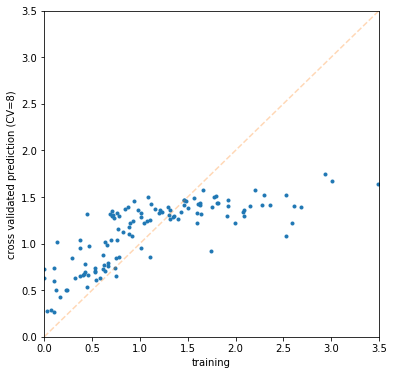

In [24]:
plot_train_pred(y, y_hat, lim)

In [25]:
mean_squared_error(y, y_hat)

0.27600460041563857

Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/z/datalake/virtual_envs/20190813T102726/Ubuntu16.04/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/z/datalake/virtual_envs/20190813T102726/Ubuntu16.04/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize ob

In [ ]:
y_test = randfor.predict(X_test_prep)

In [ ]:
plot_pred_distribution(y, y_hat, y_test)

In [ ]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/{}_randfor.csv'.format(y_col))

In [ ]:
joblib.dump(randfor, '../models/{}_randfor.pkl'.format(y_col))

# SVR

In [ ]:
params = dict(
    kernel=['rbf', 'linear', 'sigmoid', 'poly'], 
    degree=[2, 3], 
#    gamma=['auto', 0.001, 0.003, 0.01, 0.03, 0.1, 1, 3], 
    gamma=['auto', 0.001, 0.002, 0.003, 0.004, 0.005, 0.01, 0.03], 
#    C=[0.001, 0.003, 0.01, 0.03, 0.1, 1, 3, 10], 
    C=[0.1, 1, 2, 2.5, 3, 3.5, 4, 5, 10], 
#    epsilon=[0.01, 0.03, 0.1, 0.3, 0.5]
    epsilon=[0.03, 0.05, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2, 0.3]
)

grid_search = GridSearchCV(
    SVR(), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=10, 
    verbose=3, 
    iid=False, 
)

In [ ]:
grid_search.fit(X_train_prep, y)

In [ ]:
grid_search.best_estimator_

In [ ]:
svr = grid_search.best_estimator_

y_hat = svr.predict(X_train_prep)

In [ ]:
plot_train_pred(y, y_hat, lim)

In [ ]:
mean_squared_error(y, y_hat)

In [ ]:
y_test = svr.predict(X_test_prep)

In [ ]:
plot_pred_distribution(y, y_hat, y_test)

In [ ]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/{}_svr.csv'.format(y_col))

In [ ]:
joblib.dump(svr, '../models/{}_svr.pkl'.format(y_col))

# AdaboostRegressor - DecisionTreeRegressor

In [30]:
params = dict(
    base_estimator__max_depth=[3,4,5,6],
    base_estimator__min_samples_leaf=[3,4,5],
    base_estimator__min_samples_split=[3,4,5],
    base_estimator__max_features=['sqrt', 'log2', 0.3, 0.5, 0.7],
    learning_rate=[0.5, 1.0, 1.5]
)

grid_search = GridSearchCV(
    AdaBoostRegressor(
        base_estimator=DecisionTreeRegressor(random_state=random_state), 
        random_state=random_state,
        n_estimators=50, 
    ), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=16, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [31]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 540 candidates, totalling 4320 fits


Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/z/datalake/virtual_envs/20190813T102726/Ubuntu16.04/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize object, dead>
Traceback (most recent call last):
  File "/z/datalake/virtual_envs/20190813T102726/Ubuntu16.04/lib/python3.5/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/joblib/externals/loky/backend/synchronize.py", line 96, in _cleanup
    sem_unlink(name)
FileNotFoundError: [Errno 2] No such file or directory
Exception ignored in: <Finalize ob

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                              max_depth=None,
                                                                              max_features=None,
                                                                              max_leaf_nodes=None,
                                                                              min_impurity_decrease=0.0,
                                                                              min_impurity_split=None,
                                                                              min_samples_leaf=1,
                                                                              min_samples_split=2,
                                                                              min_weight_fraction_leaf=0.0,
                                                  

In [32]:
grid_search.best_estimator_

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=5,
                                                       max_features='log2',
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=5,
                                                       min_samples_split=3,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=190624,
                                                       splitter='best'),
                  learning_rate=1.0, loss='linear', n_estimators=50,
                  rand

In [33]:
adaboost = grid_search.best_estimator_

y_hat = adaboost.predict(X_train_prep)

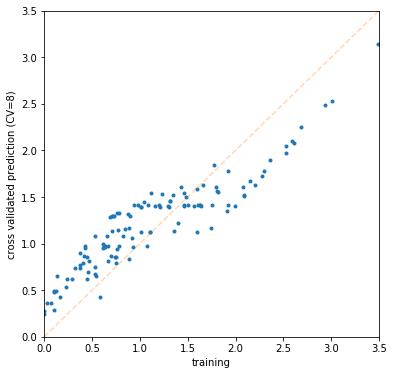

In [34]:
plot_train_pred(y, y_hat, lim)

In [35]:
mean_squared_error(y, y_hat)

0.12745492852915516

In [36]:
y_test = adaboost.predict(X_test_prep)

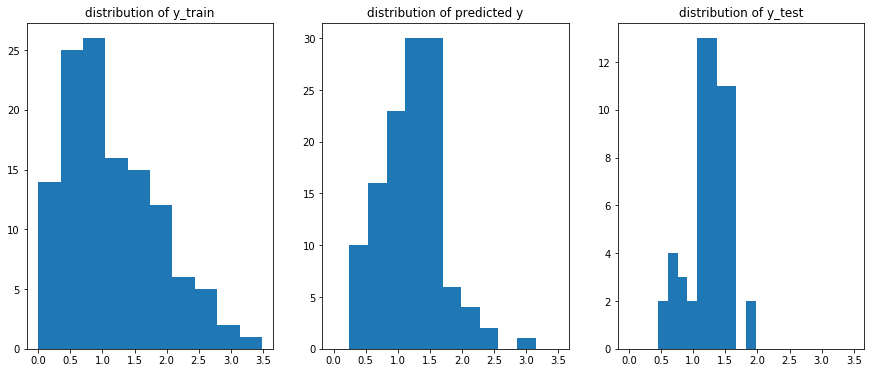

In [37]:
plot_pred_distribution(y, y_hat, y_test)

In [38]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/{}_adaboost_decisiontree.csv'.format(y_col))

In [40]:
joblib.dump(adaboost, '../models/{}_adaboost_decisiontree.pkl'.format(y_col))

['../models/odor_adaboost_decisiontree.pkl']

# AdaboostRegressor - ElasticNet

In [41]:
params = dict(
    base_estimator__alpha=[0.1, 0.3, 1.0, 3.0, 10],
    base_estimator__l1_ratio=[0, 0.4, 0.8, 1.0],
    learning_rate=[0.5, 1.0, 1.5]
)

grid_search = GridSearchCV(
    AdaBoostRegressor(
        base_estimator=ElasticNet(), 
        random_state=random_state, 
        n_estimators=50
    ), 
    param_grid=params,
    scoring='neg_mean_squared_error', 
    n_jobs=12, 
    cv=8, 
    verbose=3, 
    iid=False, 
)

In [42]:
grid_search.fit(X_train_prep, y)

Fitting 8 folds for each of 60 candidates, totalling 480 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:  3.9min
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:  5.0min
[Parallel(n_jobs=12)]: Done 480 out of 480 | elapsed:  6.3min finished
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 24.03511088640895, tolerance: 0.007923411686774188
  positive)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 41.06598472419762, tolerance: 0.011602517418387429
  positive)
/z/datalake/virtual_envs/current/Ubuntu16.04/lib/python3.5/site-packag

GridSearchCV(cv=8, error_score='raise-deprecating',
             estimator=AdaBoostRegressor(base_estimator=ElasticNet(alpha=1.0,
                                                                   copy_X=True,
                                                                   fit_intercept=True,
                                                                   l1_ratio=0.5,
                                                                   max_iter=1000,
                                                                   normalize=False,
                                                                   positive=False,
                                                                   precompute=False,
                                                                   random_state=None,
                                                                   selection='cyclic',
                                                                   tol=0.0001,
                                    

In [ ]:
grid_search.best_estimator_

In [ ]:
adaboost_elanet = grid_search.best_estimator_

y_hat = adaboost_elanet.predict(X_train_prep)

In [ ]:
plot_train_pred(y, y_hat, lim)

In [ ]:
mean_squared_error(y, y_hat)

In [ ]:
y_test = adaboost_elanet.predict(X_test_prep)

In [ ]:
plot_pred_distribution(y, y_hat, y_test)

In [ ]:
pd.DataFrame(
    y_test, 
    index=X_test.droplevel('Organism Code').index, 
    columns=['pred'], 
    dtype='float'
).to_csv('../output/{}_adaboost_elanet.csv'.format(y_col))

In [ ]:
joblib.dump(svr, '../models/{}_adaboost_elanet.pkl'.format(y_col))

# Summary

All models perform badly on large y (>1.0).